# Python realization and optimization of Biclustering via SSVD

### Chunxiao Li, Xuetong Li

In [4]:
%matplotlib inline

In [217]:
import numpy as np
import pandas as pd
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import seaborn as sns; sns.set()
from sklearn.decomposition import SparsePCA
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial
import cppimport
import time

Github link: https://github.com/xuetongli/STA-663-final-project

package can be installed from pypi using `pip install STA-663-final-project`

## 1. Abstract

As an approach of approximating large, noisy real-world data matrices, sparse singular value decomposition (SSVD) provides a low-rank, checkerboard structured matrix approximation method. The key idea is to obtain sparse left- and right-singular vectors that contains many zero elements, by inducing regularization penalties to least square regressions. An iterative algorithm using BIC is introduced for the lack of closed form solutions for l1 regularization like Lasso penalty. Optimizations including parallelism and C++ wrapping using pybind11 are performed. A simulated dataset, a lung cancer dataset, and a breast cancer dataset are used for demonstration of biclustering using SSVD. Comparative analysis between Sparse SVD, SVD, and Sparse PCA using simulated dataset is also presented.

##### Key Words: Sparse SVD; PCA; Lasso Penalty; Dimension Reduction

## 2. Background

The research paper we are using is __Biclustering via Sparse Singular Value Decomposition__ by Mihee Lee, Haipeng Shen, Jianhua Z. Huang, and J. S. Marron. This paper provides a new exploratory analysis tool for biclustering or identifying interpretable row-column associations within data matrices. As an unsupervised learning method, biclustering plays an important role in data exploratory analysis, whose goal is to interpret the structure of the data matrices. The biclustering method aims to identify the patterns in the rows set and columns set simultaneously, and it forms an interpretable checkerboard structure of the data matrices. Sparse Singular Value Decomposition(SSVD) as an approach of biclustering mainly aims to solve the problems based on high-dimension low sample size (HDLSS) data.

The biclustering method of HDLSS data is mainly applied in the fields such as, text mining/categorization, biomedical application, and microarray gene expression analysis. In the text mining, SSVD biclustering finds the document and word associations simultaneously and reveals the important relations between document and word clusters. In the field of biomedical application, SSVD biclustering can be used to associate the common properties of chemical compounds in the drug and nutritional data. As for the microarray gene expression analysis, SSVD biclustering allows simultaneously diagnose conditions from sample clusters and identify corresponding genes.

As a comparison to SVD, SSVD performs better in detecting the underlying sparse structure of HDLSS data matrices. In addition, SSVD is able to detect the sparse structure for both directions simultaneously, while SPAC fails in the unpenalized direction. However, since there is no closed form solution for regression with adaptive lasso penalty, iterative algorithm is required for SSVD method, which results in larger computation cost.

In this paper, we use BIC to choose the degree of sparsity for each round of updates and fix both weights parameters of Lasso penalty to 2, which is suggested by both Zou (2006) and Lee (2010). The resulted SSVD is used to conduct rank-1 approximation for sparse matrices with simulated noise added, and for real life lung cancer and breast cancer datasets.

## 3. Description of algorithm

The biclustering via sparse singular value decomposition algorithm can be divided into two major parts. Firstly, sparse singular value decomposition (SSVD) provides a rank-k (low-rank) matrix approximation to the data matrix, which is the combination/summation of the top k ranks SSVD layer. Each SSVD layer is obtained from the residual matrix of the previous layer, based on a penalized sum-of-squares criterion. Secondly, the biclustering part includes clustering both the row and column variables based on the left and right singular of the SSVD results respectively. The checkerboard structured matrix approximation is then obtain by sorting the singular vector within each clustering group. 

Without the loss of generality, we only consider the rank-1 matrix approximation via SSVD, which is the first SSVD layer, and the corresponding biclustering method.

##### The SSVD Algorithm

Step 1. (Initialize $u$, $s$, $v$)

Apply the standard SVD to $X$ and obtain the first SVD triplet $u$, $s$, $v$, where $X = usv^T$.

Step 2. (Update $u$, $v$):

(a). update $v$.

For each possible $\lambda_v$:
<br>
1. calculate the corresponding $v$, where $v_j = sign{(X^T u)_j}(|(X^T u)_j|-\lambda_v w_{v,j}/2)_{+}$, $\{j = 1, \cdots, d\}$.
2. calculate the corresponding $BIC$, where $BIC(\lambda_v) = \frac{||Y-\hat{Y}||^2}{nd\cdot \hat{\sigma_v^2}} + \frac{log(nd)}{nd}\hat{df}(\lambda_v)$

Pick the $\lambda_v$ that minimizes $BIC(\lambda_v)$ as the penalty parameter for $v$ and set the corresponding $v$ to be $v_{new}$, the update of the original $v$.
<br>
Rescale $v_{new}$, s.t. $v_{new} = v_{new}/s$, where $s = ||v_{new}||$.

(b). update $u$.

For each possible $\lambda_u$:
<br>
1. calculate the corresponding $u$, where $u_i = sign{(X v_{new})_i}(|(X v_{new})_i|-\lambda_u w_{u,i}/2)_{+}$, $\{i = 1, \cdots, n\}$.
2. calculate the corresponding $BIC$, where $BIC(\lambda_u) = \frac{||Z-\hat{Z}||^2}{nd\cdot \hat{\sigma_u^2}} + \frac{log(nd)}{nd}\hat{df}(\lambda_u)$

Pick the $\lambda_u$ that minimizes $BIC(\lambda_u)$ as the penalty parameter for $u$ and set the corresponding $u$ to be $u_{new}$, the update of the original $u$.
<br>
Rescale $u_{new}$, s.t. $u_{new} = u_{new}/s$, where $s = ||u_{new}||$.

(c). Set $u = u_{new}$ and $v = v_{new}$, repeat Step 2(a) and 2(b) until convergence, where both $\Delta u$ and $\Delta v$ are smaller than the tolerance.

Step 3. return $u$, $s$, $v$ at convergence.

Note: 
1. $\hat{df}(\lambda_v)$ is the degree of sparsity of $v$, which is defined by the number of $|(X^T u)_j|$s thata are greater than $\lambda_v w_{v,j}/2$.
2. $\hat{\sigma_v^2}$ is the OLS estimae of the error variance from the model $||X - u\tilde{v}||_F^2 + \lambda_v P_2(\tilde{v})$, where $\tilde{v} = sv$.
3. $\hat{df}(\lambda_u)$ is the degree of sparsity of $u$, which is defined by the number of $|(X v)_i|$s thata are greater than $\lambda_u w_{u,j}/2$.
4. $\hat{\sigma_u^2}$ is the OLS estimae of the error variance from the model $||X - \tilde{u}v||_F^2 + \lambda_u P_1(\tilde{u})$, where $\tilde{u} = su$.

Additional tips:

In the r code given by the original paper, one trick is used to (possibly) shorten run time. With $w_j^{-1}$ tends to 0, $w_j$ tends to infinity and thus the corresponding $v_j$ would definitely be 0. So the author assigned 0 directly to these $v_j$'s and calculated only the cases with nonzero $w_j^{-1}$.

## 4. Describe optimization for performance

### Data used for performance

We demonstrate the performance of the methods using both a small simulated dataset ($100\times 50$), and the large dataset from the lung cancer dataset provided in the paper ($56\times 12625$). The data are loaded below with dimensions printed. These two datasets will be further explained in later sections, and for now we only need the dimensions.

In [31]:
## Paper Lung Cancer Data
PaperData = pd.read_csv('data/LungCancerData.txt', sep=' ', header = None)
X_paper = np.array(PaperData.T)
X_paper.shape

(56, 12625)

In [32]:
## Simulated Data
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

X_star = s*u@v.T
n, d = X_star.shape
np.random.seed(2018)
X_sim = X_star + np.random.randn(n,d)
X_sim.shape

(100, 50)

### 4.1 Primary implement

We first implement the SSVD algorithm described above using plain Python in a straightforward way from the description of the algorithm, using the trick mentioned at the end of the last section. Then, a function for plotting the clusters of rank 1 approximation using the results of SSVD function is provided.

In [34]:
def SSVD_paper(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for first layer
    
    X = data matrix
    gamma1, gamma2 = weight parameters, default set to 2
    tol = tolerance for convergence, default set to 1e-4
    max_iter = maximum number of iterations, default set to 100
    
    If converged, return:
    
    u = u vector of Sparse SVD
    s = largest singular value from SVD
    v = v vector of Sparse SVD
    niter = number of iteration until convergence
    
    If not converged, print:
    
    "Fail to converge! Increase the max_iter!"
    
    Example usage:
    
    u, s, v, niter = SSVD_primary(X)    
    """
    U, S, V = np.linalg.svd(X)
    u = U.T[0]
    v = V.T[0]
    s = S[0]

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2s[i])*(np.abs(Xu_w_nonzero)-lambda2s[i])
            temp = np.zeros((d,1))
            temp[index] = temp_partial/w2_inv_nonzero
            BICs[i] = np.sum((X-u@temp.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda2 = lambda2s[best]
        v_new_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2)*(np.abs(Xu_w_nonzero)-lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X @ v/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda1/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1s[i])*(np.abs(Xv_w_nonzero)-lambda1s[i])
            temp = np.zeros((n,1))
            temp[index] = temp_partial/w1_inv_nonzero
            BICs[i] = np.sum((X-temp@v.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda1 = lambda1s[best]
        u_new_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1)*(np.abs(Xv_w_nonzero)-lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge! Increase the max_iter!")
        
    return(np.ravel(u), s, np.ravel(v), niter)

In [132]:
%%time 
u, s, v, niter = SSVD_paper(X_sim)

CPU times: user 116 ms, sys: 300 ms, total: 416 ms
Wall time: 53.5 ms


In [134]:
%%time 
u, s, v, niter = SSVD_paper(X_paper)

CPU times: user 9min 53s, sys: 15min 24s, total: 25min 17s
Wall time: 3min 24s


In [153]:
def plotClusters(u, s, v, group, tresh):
    """Plotting Clusters for rank 1 approximation
    
    u, s, v = return values of SSVD function
    group = vector of known groups, None if no grouping is known
    tresh = value for discarding insignificant rows.
    
    return:
    Heatmap of rank 1 approximated clusters
    
    Example usage:
    
    u, s, v, niter = SSVD_primary(X)
    plotClusters(u,s,v,None,0)
    """
    first = s*u.reshape((-1, 1))@v.reshape((1, -1))

    groups = np.unique(group)
    row_idx = np.empty(0, dtype = 'int')
    for i in range(len(groups)):
        idx, = np.where(group == groups[i])
        idx_ = idx[np.argsort(u[idx])]
        row_idx = np.concatenate((row_idx, idx_))

    col_nonzero = np.argsort(np.abs(v))[tresh:]
    v_nonzero = v[col_nonzero]
    first_nonzero = first[:,col_nonzero]
    col_idx = np.argsort(v_nonzero)

    ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

Then we try to optimize the SSVD function.

### 4.2 Python optimization

First we provide an update using plain python. The following 2 major updates are provided:

1. Since we are only using $u$ and $v$ corresponding to the highest singular value, the full svd is not necessary. Thus we use sparsesvd with argument $k=1$ instead of svd, and get only the u and v corresponding to the highest singular value.
2. Discard the trick of separating infinite weights and finite weights. This trick cannot shorten runtime for both small and large dataset in python. So for the sake of more straightforward and concise coding structure, we remove the use of this trick.

In [125]:
def SSVD_python(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for first layer with python optimization
    
    X = data matrix
    gamma1, gamma2 = weight parameters, default set to 2
    tol = tolerance for convergence, default set to 1e-4
    max_iter = maximum number of iterations, default set to 100
    
    If converged, return:
    
    u = u vector of Sparse SVD
    s = largest singular value from SVD
    v = v vector of Sparse SVD
    niter = number of iteration until convergence
    
    If not converged, print:
    
    "Fail to converge! Increase the max_iter!"
    
    Example usage:
    
    u, s, v, niter = SSVD_primary(X)    
    """
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            v_temp = np.sign(Xu)*(np.abs(Xu) >= lambda2s[i] / w2_inv)*(np.abs(Xu) - lambda2s[i] / w2_inv)
            BICs[i] = np.sum((X-u@v_temp.T)**2)/sigma_sq + np.sum(v_temp!=0)*np.log(n*d)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            u_temp = np.sign(Xv)*(np.abs(Xv) >= lambda1s[i] / w1_inv)*(np.abs(Xv) - lambda1s[i] / w1_inv)
            BICs[i] = np.sum((X-u_temp@v.T)**2)/sigma_sq + np.sum(u_temp!=0)*np.log(n*d)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [126]:
%%time 
u, s, v, niter = SSVD_python(X_sim)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 44.9 ms


In [135]:
%%time 
u, s, v, niter = SSVD_python(X_paper)

CPU times: user 8min 30s, sys: 15min 6s, total: 23min 36s
Wall time: 3min 4s


Compared to primary version, the most significant improve is the CPU time for small simulated data, which showed significant decrease. The wall time for simulated data also slightly decreased. For the large paper data, there is some improvement in the CPU times, while the Wall time is only slightly improved.

### 4.3. Parallelism using multiprocessing

Although the general updating process is sequential, the BIC calculation is highly parallel. So we try performing parallelism on the BIC part using multiprocessing. Since for each for loop, only the input of $\lambda$ changes, we are able to use partial functions, instead of providing multiple arguments to `pool.map`. This code is based on the python optimized version.

In [137]:
def BIC_v(lambda2, candidate, w_inv, X, u, sigma_sq, n, d):
    """Helper function. Calculate BIC for updating v"""
    v_temp = np.sign(candidate)*(np.abs(candidate) >= lambda2 / w_inv)*(np.abs(candidate) - lambda2 / w_inv)
    BIC = np.sum((X-u@v_temp.T)**2)/sigma_sq + np.sum(v_temp!=0)*np.log(n*d)
    return BIC

def BIC_u(lambda1, candidate, w_inv, X, v, sigma_sq, n, d):
    """Helper function. Calculate BIC for updating u"""
    u_temp = np.sign(candidate)*(np.abs(candidate) >= lambda1 / w_inv)*(np.abs(candidate) - lambda1 / w_inv)
    BIC = np.sum((X-u_temp@v.T)**2)/sigma_sq + np.sum(u_temp!=0)*np.log(n*d)
    return BIC

def SSVD_multiprocessing(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """"SSVD for first layer using multiprocessing
    
    X = data matrix
    gamma1, gamma2 = weight parameters, default set to 2
    tol = tolerance for convergence, default set to 1e-4
    max_iter = maximum number of iterations, default set to 100
    
    If converged, return:
    
    u = u vector of Sparse SVD
    s = largest singular value from SVD
    v = v vector of Sparse SVD
    niter = number of iteration until convergence
    
    If not converged, print:
    
    "Fail to converge! Increase the max_iter!"
    
    Example usage:
    
    u, s, v, niter = SSVD_primary(X)    
    """
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BIC_v_partial = partial(BIC_v, candidate = Xu, w_inv = w2_inv, X = X, u = u, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_v_partial, lambda2s)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BIC_u_partial = partial(BIC_u, candidate = Xv, w_inv = w1_inv, X = X, v = v, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_u_partial, lambda1s)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [138]:
%%time 
u, s, v, niter = SSVD_multiprocessing(X_sim)

CPU times: user 104 ms, sys: 132 ms, total: 236 ms
Wall time: 1.02 s


In [139]:
%%time 
u, s, v, niter = SSVD_multiprocessing(X_paper)

CPU times: user 1.64 s, sys: 2.54 s, total: 4.18 s
Wall time: 4min 4s


Compared to primary version, the most significant improve is the CPU time for large paper data, which takes only a few seconds. However, the wall time takes longer than before. For the small simulated data, the CPU time decreased while again the Wall time increased.

### 4.4 C++ and pybind11

The SSVD function is re-written in C++ and wrapped using pybind11. The C++ code is intended to base on the python optimized version. However, since we are enable to find a sparsesvd equivalent C++ function, Eigen JacobiSVD is used. Theoretically, the performance should be even better given a C++ function that can calculate only the $u$ and $v$ vetors corresponding to the most significant singular value $s$.

In [140]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <Eigen/Dense>

namespace py = pybind11;

struct Decomposition {
    Decomposition(const Eigen::MatrixXd X) : X(X) { }
    void SSVD() { 
 
        double gamma1 = 2;
        double gamma2 = 2;
        double tol = 1e-4;
        int max_iter = 10;
        double inf = std::numeric_limits<double>::infinity();

        Eigen::JacobiSVD<Eigen::MatrixXd> svd(X, Eigen::ComputeThinU | Eigen::ComputeThinV);
        Eigen::VectorXd s = svd.singularValues().head(1);
        Eigen::MatrixXd u = svd.matrixU().leftCols(1);
        Eigen::MatrixXd v = svd.matrixV().leftCols(1);

        int n = X.rows();
        int d = X.cols();
        double u_delta = 1;
        double v_delta = 1;
        int niter = 0;
        double SST = X.unaryExpr([](double x) { return pow(x, 2); }).sum();

        Eigen::MatrixXd Xt, Xu, w2_inv, v_temp, v_temp_t, v_new;
        Eigen::VectorXd lambda2s(d+1);
        double sigma_sq2, lambda2_temp, part3, part4;
        Eigen::VectorXd BIC2s, sign, part1, part2;    

        Eigen::MatrixXd Xv, w1_inv, u_temp, v_t, u_new;
        Eigen::VectorXd lambda1s(n+1);
        double sigma_sq1, lambda1_temp, part7, part8;
        Eigen::VectorXd BIC1s, sign1, part5, part6;

        double best1_BIC, best2_BIC;
        bool converge = true;

        while((u_delta > tol) | (v_delta > tol)){
            niter += 1;

            // update v
            Xt = X.transpose();
            Xu = Xt * u;
            w2_inv = pow(abs(Xu.array()), gamma2);

            sigma_sq2 = abs(SST - pow(Xu.array(), 2).sum())/(double)(n*d-d);


            lambda2s << abs(Xu.array() * w2_inv.array()), 0.0;
            std::unique(lambda2s.data(), lambda2s.data()+lambda2s.size());
            std::sort(lambda2s.data(), lambda2s.data()+lambda2s.size());

            BIC2s = Eigen::VectorXd::Ones(lambda2s.size() - 1) * inf;

            best2_BIC = inf;
            sign =  Xu.unaryExpr([](double x) { return (0.0 < x) - (x < 0.0); }).array().cast<double>();
            for(int i = 0; i < BIC2s.size(); i++){
                lambda2_temp = lambda2s[i];
                part1 = (abs(Xu.array()) >= (lambda2_temp / w2_inv.array())).array().cast<double>();
                part2 = (abs(Xu.array()) - (lambda2_temp / w2_inv.array())).array();

                v_temp = sign.array() * part1.array() * part2.array();
                v_temp_t = v_temp.transpose();

                part3 = pow((X - u * v_temp_t).array(), 2).sum()/sigma_sq2/(n*d);
                part4 = (v_temp.array() != 0).array().cast<double>().sum()*log(n*d)/(n*d);
                BIC2s[i] = part3 + part4;

                if(BIC2s[i] < best2_BIC){
                    best2_BIC = BIC2s[i];
                    v_new = v_temp;
                }  
            }

            v_new = v_new.array()/sqrt(pow(v_new.array(), 2).sum());

            v_delta = sqrt(pow((v.array()-v_new.array()), 2).sum());
            v = v_new;


            // update u
            Xv = X * v;
            w1_inv = pow(abs(Xv.array()), gamma1);

            sigma_sq1 = abs(SST - pow(Xv.array(), 2).sum())/(double)(n*d-n);

            lambda1s << abs(Xv.array() * w1_inv.array()), 0.0;
            std::unique(lambda1s.data(), lambda1s.data()+lambda1s.size());
            std::sort(lambda1s.data(), lambda1s.data()+lambda1s.size());

            BIC1s = Eigen::VectorXd::Ones(lambda1s.size() - 1) * inf;

            best1_BIC = inf;
            sign1 =  Xv.unaryExpr([](double x) { return (0.0 < x) - (x < 0.0); }).array().cast<double>();
            for(int i = 0; i < BIC1s.size(); i++){
                lambda1_temp = lambda1s[i];
                part5 = (abs(Xv.array()) >= (lambda1_temp / w1_inv.array())).array().cast<double>();
                part6 = (abs(Xv.array()) - (lambda1_temp / w1_inv.array())).array();

                u_temp = sign1.array() * part5.array() * part6.array();
                v_t = v.transpose();

                part7 = pow((X - u_temp * v_t).array(), 2).sum()/sigma_sq1/(n*d);
                part8 = (u_temp.array() != 0).array().cast<double>().sum()*log(n*d)/(n*d);
                BIC1s[i] = part7 + part8;

                if(BIC1s[i] < best1_BIC){
                    best1_BIC = BIC1s[i];
                    u_new = u_temp;
                }
            }

            u_new = u_new.array()/sqrt(pow(u_new.array(), 2).sum());

            u_delta = sqrt(pow((u.array()-u_new.array()), 2).sum());
            u = u_new;


            if(niter > max_iter){
                converge = false;
                break;
            }
        }

        niter_result = niter;
        u_result = u;
        v_result = v;
        s_result = s;
        converge_result = converge;
    }
    const Eigen::MatrixXd getX() const { return X; }
    const Eigen::MatrixXd getU() const { return u_result; }
    const Eigen::MatrixXd getV() const { return v_result; }
    const Eigen::VectorXd getS() const { return s_result; }
    const int getNiter() const { return niter_result; }
    const bool getConverge() const { return converge_result; }

    Eigen::MatrixXd X;
    Eigen::MatrixXd u_result;
    Eigen::MatrixXd v_result;
    Eigen::VectorXd s_result;
    int niter_result;
    bool converge_result;
 };


PYBIND11_MODULE(wrap, m) {
     py::class_<Decomposition>(m, "Decomposition")
         .def(py::init<const Eigen::MatrixXd>())
         .def("SSVD", &Decomposition::SSVD)
         .def("getX", &Decomposition::getX)
         .def("getU", &Decomposition::getU)
         .def("getV", &Decomposition::getV)
         .def("getS", &Decomposition::getS)
         .def("getNiter", &Decomposition::getNiter)
         .def("getConverge", &Decomposition::getConverge);

}

Overwriting wrap.cpp


In [141]:
cppimport.force_rebuild()
code = cppimport.imp("wrap")

In [145]:
%%time

p = code.Decomposition(X_sim)
p.SSVD()
u = p.getU()
v = p.getV()

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 66 ms


In [146]:
%%time

p = code.Decomposition(X_paper)
p.SSVD()
u = p.getU()
v = p.getV()

CPU times: user 10min 41s, sys: 4.6 s, total: 10min 46s
Wall time: 10min 42s


Compared to primary version, the CPU time for large paper data is shortened. However, the wall time takes longer than before. For the small simulated data, the CPU time decreased significantly, while the Wall time increased slightly. One thing to notice is that, for c++ version, the total CPU time and Wall time are exactly the same.

To conclude, the optimized plain python version provides the best wall times for both simulated and paper data. So `SSVD_python` is used for the later discussions.

## 5. Applications to simulated data sets

A sparse matrix $X^*$ is created using $\tilde{u}$ and $\tilde{v}$ given below.

$\tilde{u} = [10,9,8,7,6,5,4,3,r(2,17),r(0,75)]^T$, and 

$\tilde{v} = [10,-10,8,-8,5,-5,r(3,5),r(-3,5),r(0,34)]^T$, where $r(a,b)$ means repeat $a$ for $b$ times.

$u$ and $v$ are normalized $\tilde{u}$ and $\tilde{v}$. Take $s=50$ and construct $X^* = suv^T$.

The checkerboard pattern of the true data is plotted.

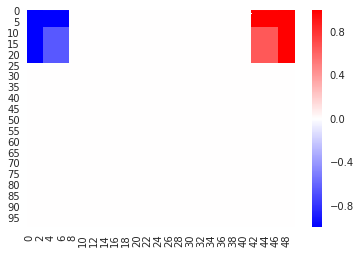

In [252]:
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

groups = np.concatenate((np.ones(11-3), np.ones(17)*2, np.ones(75)*3))
plotClusters(u.reshape(-1), s, v.reshape(-1), groups, 0)

Iid standard normal noises are added to each element of $X^*$ and generate $X_{sim}$. The clustering using rank 1 approximation of normal SVD is blurred as below.

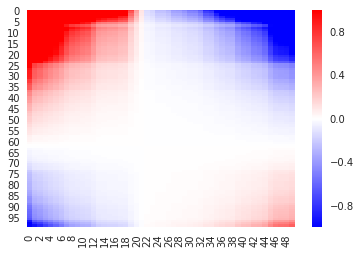

In [253]:
X_star = s*u@v.T
n, d = X_star.shape
np.random.seed(2018)
X_sim = X_star + np.random.randn(n,d)
U, S, V = np.linalg.svd(X_sim)
u = U.T[0]
s = S[0]
v = V.T[0]
groups = np.concatenate((np.ones(11-3), np.ones(17)*2, np.ones(75)*3))
plotClusters(u.reshape(-1), s, v.reshape(-1), groups, 0)

Compared to when `SSVD_python` is used to get rank 1 approximation of the matrix:

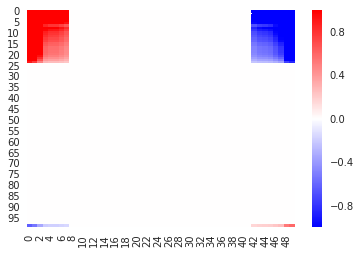

In [324]:
u, s, v, niter = SSVD_python(X_sim)

groups = np.concatenate((np.ones(11-3), np.ones(17)*2, np.ones(75)*3))
plotClusters(u, s, v, groups, 0)

Clear checkerboard pattern can be observed from the plot, so the noise in the simulated data is successfully removed by the SSVD function, and the result matches the underlining true data.

## 6. Applications to real data sets

### 6.1 Paper data set: Lung Cancer

The paper illustrated SSVD using a microarray gene expression data on lung cancer. The data contains the expression levels of 12625 genes from 56 subject. The subjects are known to be grouped into 4 groups:

Subject 1 to 20 are pulmonary carcinoid samples; 

Subject 21 to 33 are colon cancer metastasis samples;

Subject 34 to 50 are normal lung samples;

Subject 51 to 56 are small cell carcinoma samples.

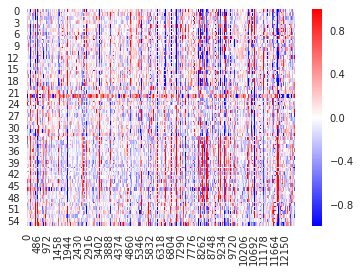

In [246]:
PaperData = pd.read_csv('data/LungCancerData.txt', sep=' ', header = None)
X_paper = np.array(PaperData.T)
sns.heatmap(X_paper, vmin=-1, vmax=1, cmap = 'bwr')
pass

Then `SSVD_python` is used to get rank 1 approximation of the matrix.

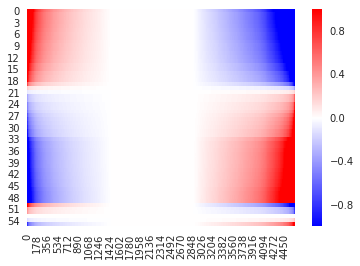

In [213]:
u, s, v, niter = SSVD_python(X_paper)
groups = np.concatenate((np.ones(20), np.ones(33-20)*2, np.ones(50-33)*3, np.ones(56-50)*4))
plotClusters(u, s, v, groups, 8000)

As in the original paper, 8000 insignificant genes in the middle white area are ignored. The resulted plot matches the 1st Layer approximation plot from the paper, so our realization of the algorithm is successful. The SSVD algorithm naturally performs gene selection as the number of selected (colored) genes is much smaller than the total number of genes. Also, the selected genes correspond to the original grouping of the subjects, as the clear boundaries observed match the grouping described above.

### 6.2 Outside data set: Breast Cancer

Microarray data set of van’t Veer breast cancer is provided on http://www.broadinstitute.org/cgi-bin/cancer/datasets.cgi, where the expression level of 1213 genes of 98 subjects are provded. The 3 groups of the genes are also given in `BreastCancerLabels.txt`. Array S54 (index = 9) was removed because it is an outlier according to the manual of fabia package. 

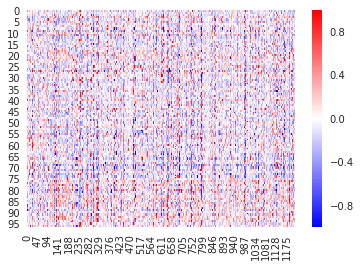

In [325]:
OutData = pd.read_csv('data/BreastCancerData.txt', sep=' ', header=0)
X_Out = np.array(OutData.T)
sns.heatmap(X_Out, vmin=-1, vmax=1, cmap = 'bwr')
pass

Then `SSVD_python` is used to get rank 1 approximation of the matrix.

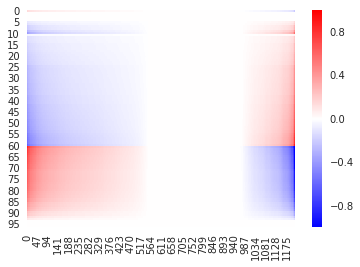

In [322]:
u, s, v, niter = SSVD_python(X_Out)
groups = pd.read_csv('data/BreastCancerLabels.txt', sep=' ', header = -1)
groups = np.delete(np.array(groups)[0],9)
plotClusters(u, s, v, groups, 0)

The resulted rank 1 approximation appears clear checkerboard pattern. The three groups and the insignificant genes (white area) can be identified from the plot as well.

## 7. Comparative analysis with competing algorihtms

The SSVD algorithm is compared with `numpy.linalg.svd` and `sklearn.decomposition.SparsePCA`, since these are 3 different ways to conduct matrix decomposition. As in the SSVD method, weight parameter for SPCA function is set to 2.Rank 1 decomposition results are compared with the true $u$ and $v$ defined in simulation section, and it is tested if the three methods can correctly identify the sparse structure in the matrix with noise added. The times used for each method are also recorded.

In [222]:
def evaluation(estimate, label, n_sim):
    """Helper function used to calcualte evaluations"""
    num_zero = np.sum(estimate==0)/n_sim
    num_zero_true =  np.sum((estimate==0)& (label==0).reshape((-1,1)))/n_sim
    p_zero_true = num_zero_true/np.sum(label==0)
    num_noneZero_true = np.sum((estimate!=0)& (label!=0).reshape((-1,1)))/n_sim
    p_noneZero_true = num_noneZero_true/np.sum(label!=0)
    miss_rate = (label.shape[0]-num_zero_true-num_noneZero_true)/label.shape[0]
    return np.around([num_zero, p_zero_true, p_noneZero_true, miss_rate], decimals=4)

In [227]:
def sim_eval(s,u,v,n_sim=100):
    """Helper function used to conduct simulated comparative analysis"""
    X_star = s*u@v.T
    n, d = X_star.shape

    u_SSVD = np.zeros((n, n_sim))
    u_svd = np.zeros((n, n_sim))
    u_SPAC = np.zeros((n, n_sim))
    v_SSVD = np.zeros((d, n_sim))
    v_svd = np.zeros((d, n_sim))
    v_SPAC = np.zeros((d, n_sim))
    
    time_SSVD = 0
    time_svd = 0
    time_SPAC = 0

    for i in range(n_sim):
        X_sim = X_star + np.random.randn(n,d)
        
        start_time = time.time()
        u_SSVD[:,i], s, v_SSVD[:,i], niter = SSVD_python(X_sim)
        time_SSVD += time.time()-start_time

        start_time = time.time()
        U_svd, s, V_svd = np.linalg.svd(X_sim)
        u_svd[:,i] = U_svd[:,0]
        v_svd[:,i] = V_svd[0,:]
        time_svd += time.time()-start_time
        
        start_time = time.time()
        SPAC = SparsePCA(n_components=1, alpha=2)
        SPAC.fit(X_sim)
        v_SPAC[:,i] = SPAC.components_[0]
        SPAC.fit(X_sim.T)
        u_SPAC[:,i] = SPAC.components_[0]
        time_SPAC += time.time()-start_time
        
    times = np.array([time_SSVD, time_svd, time_SPAC])
        
    table = np.empty((6, 4))
    i = 0
    for item in [u_SSVD, u_svd, u_SPAC]:
        table[(2*i),:] = evaluation(item, u, n_sim)
        i += 1
    i = 0
    for item in [v_SSVD, v_svd, v_SPAC]:
        table[(2*i+1),:] = evaluation(item, v, n_sim)
        i += 1
            
    return(table, times)

In [228]:
# True model
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

# Simulation
table, times = sim_eval(s,u,v)

In [229]:
df = pd.DataFrame(data=table)
df.columns = ['Avg # of zeros', 'Percentage of correctly identified zeros',
             'Percentage of correctly identified nonzeros', 'Misclassification rate']
df['Singular Vector'] = ['u', 'v']*3
df['Method'] = np.repeat(['SSVD', 'SVD', 'SPCA'],2)
df['Misclassification rate'] = round((df['Misclassification rate'] * 100),4).astype(str) + '%'
df['Percentage of correctly identified zeros'] = round((df['Percentage of correctly identified zeros'] * 100),4).astype(str) + '%'
df['Percentage of correctly identified nonzeros'] = round((df['Percentage of correctly identified nonzeros'] * 100),4).astype(str) + '%'
df.groupby(['Method', 'Singular Vector']).max()

Avg # of zeros  \
Method Singular Vector                   
SPCA   u                         71.66   
       v                         32.50   
SSVD   u                         74.10   
       v                         33.84   
SVD    u                          0.00   
       v                          0.00   

                       Percentage of correctly identified zeros  \
Method Singular Vector                                            
SPCA   u                                                 95.43%   
       v                                                 95.59%   
SSVD   u                                                 98.45%   
       v                                                 99.53%   
SVD    u                                                   0.0%   
       v                                                   0.0%   

                       Percentage of correctly identified nonzeros  \
Method Singular Vector                                               
SPCA   u                                                    99.64%   
       v                                                    100.0%   
SSVD   u                                                    98.96%   
       v                                                    100.0%   
SVD    u                                                    100.0%   
       v                                                    100.0%   

                       Misclassification rate  
Method Singular Vector                         
SPCA   u                                3.52%  
       v                                 3.0%  
SSVD   u                                1.42%  
       v                                0.32%  
SVD    u                                75.0%  
       v                                68.0%

In [234]:
df = pd.DataFrame(data=times)
df.columns = ['total time used/ s']
df.index = np.array(['SSVD', 'SVD', 'SPCA'])
df

,total time used/ s
SSVD,4.762883
SVD,0.211167
SPCA,10.494583


The SSVD function results in the lowest misclassification rate, thus performs the best on identifying the sparse structure of the matrix. SPCA also provides low misclassification rate, while SVD method is completely unable to extract the sparsity. Between the 2 methods that are effective in detecting sparse structure, SSVD is much faster than SPCA. So in general, SSVD provides a faster way of better identifying sparsity in HDLSS data.

To conclude as a comparison to SVD, SSVD performs better in detecting the underlying sparse structure of HDLSS data matrices. In addtion, SSVD is able to detect the sparse structure for both directions simultaneously, while SPAC fails in the unpenalized direction.

## Discussion/conclusion

Your thoughts on the algorithm. Does it fulfill a particular need? How could it be generalized to other problem domains? What are its limiations and how could it be improved further?


This sparse singular value decomposition (SSVD) provides a low-rank, checkerboard structured matrix approximation method for HDLSS datasets, using adaptive lasso penalty. According to its successful implements on both simulated data and real life biomedial data, SSVD is able to detect the sparse structure of the data even with rank 1 approximation only. When used for microarray gene expression analysis, SSVD biclustering is able to conduct gene selection and can take into account potential gene-subject interactions, since the selection is performed on both rows and columns simutaneously.

The biclustering method of HDLSS data can also be applied on text mining/categorization and biomedical application. In the text mining, SSVD biclustering would be able to detect the document and word associations simultaneously and reveals the important relations between document and word clusters. In the field of biomedical application, SSVD biclustering may be used to associate the common properties of chemical compounds in the drug and nutritional data.

One possible improvement left for the future is to try other sparsity-inducing penalties. In this report we focused on adaptive lasso penalty with weight parameter fixed to 2. Other weights and even other penalties could be taken into consideration in the future.

## References/bibliography

Hochreiter, S. (2017). Fabia: factor analysis for bicluster acquisition, manual for the r package. https://www.bioconductor.org/packages/3.7/bioc/vignettes/fabia/inst/doc/fabia.pdf

Lee, M., Shen, H., Huang, J., and Marron, J. (2010). Biclustering via sparse singular value decomposition. *Biometrics* **66**, 1087-1095.

Zou, H. (2006). The adaptive lasso and its oracle properties. *Journal of the American Statistical Association* **101**, 1418-1429.
